In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sys

from collections import defaultdict
from copy import copy
from itertools import combinations
from IPython.display import Image
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

sns.set_theme(style="darkgrid")

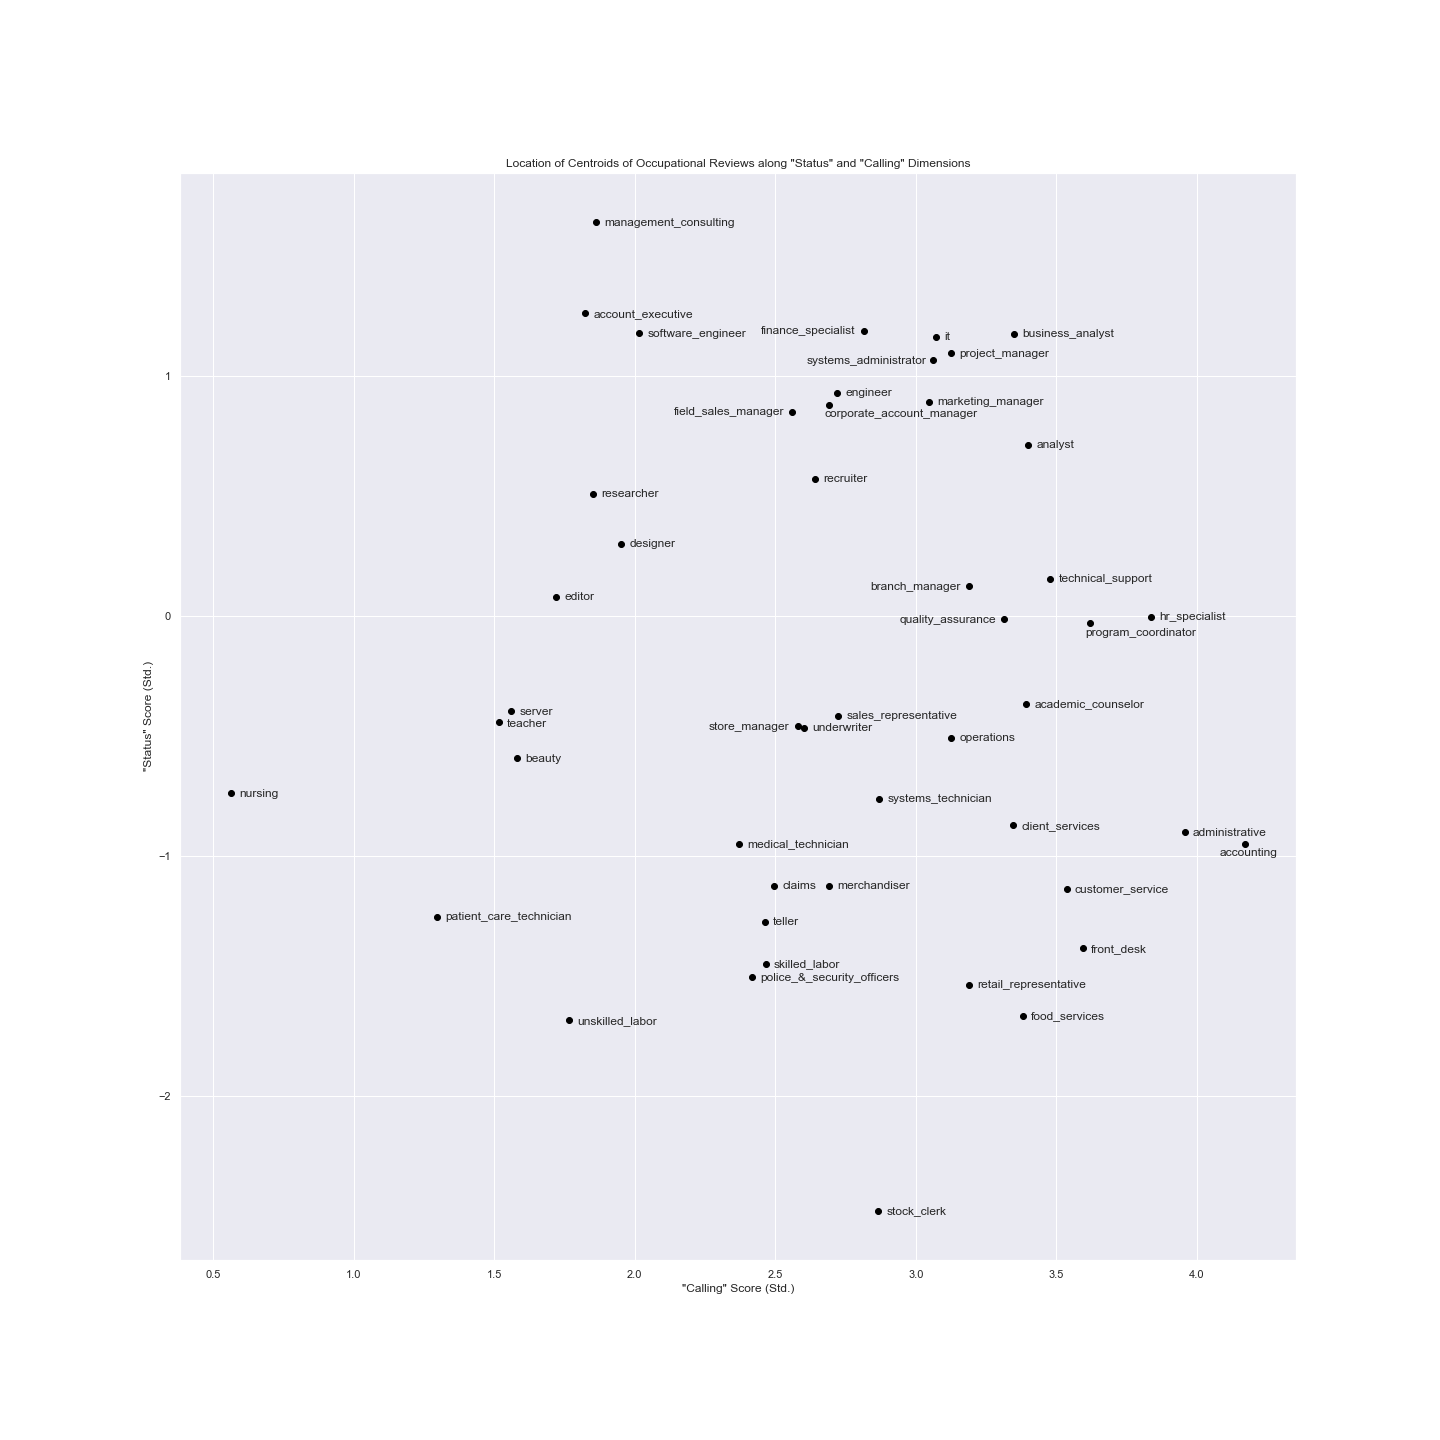

In [32]:
Image(filename="occ_cent_dist.png")

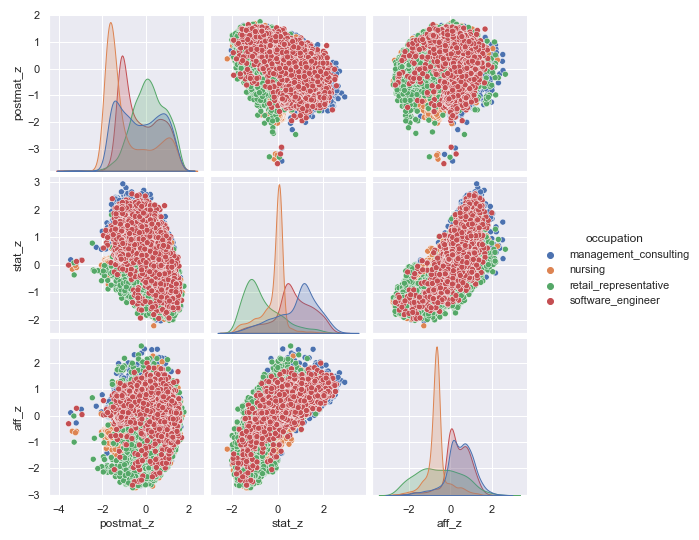

In [33]:
Image(filename="pairplot2.png") 

### Exploratory analyses: using techniques that identify bias in word embeddings to extract features associated with the kinds of individualism linked to different orientations toward work (inspired by Bellah et al., 1996).

### The model used to embed the employer reviews is a Siamese distilBERT network (Reimers & Gurevych, 2019) pretrained for NLI and STS-B and then fine-tuned on my data while it learned to distinguish between occupations (code for that project: https://github.com/sheridanstewart/cs230_sharing).

In [3]:
model = SentenceTransformer("final_proj_model_TUNING_softmax_only") # SBERT model trained for CS 230 project

In [4]:
train_df = pd.read_json("train_df_final.json")
label2occ = train_df[["labels", "occupation"]].drop_duplicates().set_index("labels").to_dict()["occupation"]
occ2label = {value:key for key, value in label2occ.items()}

del train_df

In [5]:
lab_to_vecs_dict = pickle.load(open("lab_to_rating_to_vec.p", "rb"))

In [6]:
print(len(lab_to_vecs_dict.keys()))
print(set([len(v) for v in lab_to_vecs_dict.values()]))

49
{5}


In [7]:
# To dataframe 
dfs = []
keys = sorted(list(lab_to_vecs_dict.keys()))

for key in keys:
    for rating in range(1,6):
        vecs, texts, idx = zip(*lab_to_vecs_dict[key][rating])
        tmp = pd.DataFrame(vecs)
#         tmp["text"] = texts
#         tmp["idx"] = idx
        tmp["labels"] = [key] * len(vecs)
        tmp["rating"] = [rating] * len(vecs)
        tmp["occupation"] = [label2occ[key]] * len(vecs)
        dfs.append(tmp)
        
df = pd.concat(dfs)
del dfs

In [8]:
occ_centroids = defaultdict(lambda: {}) # centroids for each occupation for each 1-5 rating

for key in keys:
    for rating in range(1,6):
        m = np.mean(df[(df["labels"]==key) & (df["rating"]==rating)][df.columns[:768]], axis = 0)
        m = np.array(m).reshape(m.shape[0], 1).T
        occ_centroids[key][rating] = m

In [9]:
overall_occ_centroids = {}

for key in keys:
    vecs = []
    for rating in range(1,6):
        m = occ_centroids[key][rating]
        vecs.append(m)
    m_occ = np.mean(vecs, axis=0)
    overall_occ_centroids[key] = m_occ

In [10]:
rating_centroids = {} # centroids for one-star reviews, two-star reviews, ..., five-star reviews 

for rating in range(1,6):
    m = np.mean(df[df["rating"]==rating][list(df.columns)[:768]], axis = 0)
    rating_centroids[rating] = m

In [11]:
def add_to_new_pairs(s1, s2, pairs):
    pairs.append([s1, s2])


def check_components(pairs, num_components=10):
    """
    Code adapted from doPCA() method at
    https://github.com/tolga-b/debiaswe/blob/master/debiaswe/we.py
    """
    matrix = []
    num_components = min(len(pairs), num_components)
    for a, b in pairs:
        av = model.encode(a)
        bv = model.encode(b)
        center = (av + bv)/2
        matrix.append(av - center)
        matrix.append(bv - center)
    pca = PCA(n_components = num_components)
    pca.fit(np.array(matrix))
    plt.bar(range(num_components), pca.explained_variance_ratio_)
    plt.show()
    print(pca.explained_variance_)
    print(pca.explained_variance_ratio_)
    print(pca.components_[0].shape)
    return pca.components_[0]


def vec_and_title(label):
    """
    Return overall centroid of reviews associated with an occupation
    """
    occ = label2occ[label]
    m_occ = overall_occ_centroids[label]
    return (m_occ, occ)

vecs_and_titles = [vec_and_title(label) for label in lab_to_vecs_dict.keys()]

### "Work as a career" = orientation toward success, prestige, influence.

### Identifying a dimension associated with these concerns:

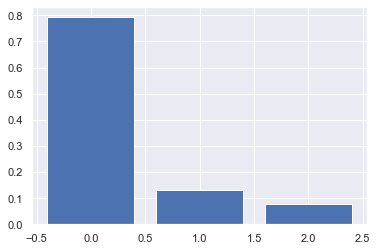

[55.92876   9.198303  5.433403]
[0.79263556 0.13036051 0.07700346]
(768,)


In [16]:
status_pairs = []
add_to_new_pairs("prestigious", "shameful", status_pairs)
add_to_new_pairs("powerful", "weak", status_pairs)
add_to_new_pairs("influential", "invisible", status_pairs)
status_direction = check_components(status_pairs)

### "Work as a calling" = doing what one is meant to do, so fulfilling one's purpose, finding fulfillment, becoming whole

### Identifying a dimension associated with these concerns:

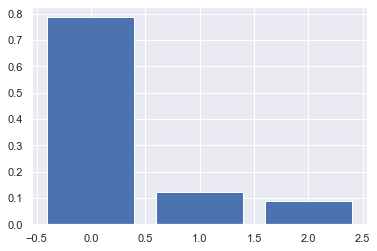

[62.692085   9.779341   7.1884346]
[0.78699774 0.12276381 0.09023917]
(768,)


In [17]:
postmat_pairs = []
add_to_new_pairs("fulfillment", "disappointment", postmat_pairs)
add_to_new_pairs("purpose", "accident", postmat_pairs)
add_to_new_pairs("whole", "part", postmat_pairs)
postmat_direction = check_components(postmat_pairs)

### Comparison to an "affluence" dimension seeded with word pairs from https://github.com/KnowledgeLab/GeometryofCulture

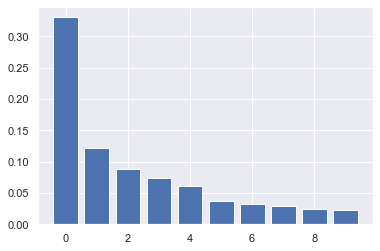

[18.675173   6.8950844  4.980521   4.159918   3.418914   2.0874124
  1.8493117  1.6461004  1.3892963  1.3243451]
[0.33069265 0.12209545 0.08819312 0.0736622  0.06054079 0.03696308
 0.03274689 0.0291485  0.02460111 0.02345098]
(768,)


In [18]:
f = "affluence_pairs.csv"
affluence_pairs = pd.read_csv(f)
affluence_pairs = affluence_pairs.to_numpy()

affluence_direction = check_components(affluence_pairs)

In [19]:
cosine_similarity(postmat_direction.reshape(1, -1), status_direction.reshape(1, -1))

array([[-0.12316073]], dtype=float32)

### Finding position of each review along these dimensions

In [20]:
def apply_direction(x, direction):
    return x.reshape(1, -1).dot(direction)[0]

X = df[df.columns[:768]].to_numpy()
print(X.shape)

df["postmaterialism"] = list(map(lambda x: apply_direction(x, postmat_direction), X))
df["status"] = list(map(lambda x: apply_direction(x, status_direction), X))
df["affluence"] = list(map(lambda x: apply_direction(x, affluence_direction), X))

X = df["postmaterialism"].values
df["postmat_z"] = (X - np.mean(X))/np.std(X, ddof=1)

X = df["status"].values
df["stat_z"] = (X - np.mean(X))/np.std(X, ddof=1)

X = df["affluence"].values
df["aff_z"] = (X - np.mean(X))/np.std(X, ddof=1)

(490000, 768)


In [21]:
df[["postmat_z", "stat_z", "aff_z"]].corr("spearman")

,postmat_z,stat_z,aff_z
postmat_z,1.000000,-0.364798,0.009112
stat_z,-0.364798,1.000000,0.734667
aff_z,0.009112,0.734667,1.000000


In [22]:
posit_postmat = sorted([(m_occ.dot(postmat_direction)[0], occ) for m_occ, occ in vecs_and_titles], key=lambda x: x[1])
postmat_vals, postmat_occs = zip(*posit_postmat)
postmat_vals /= np.std(postmat_vals, ddof=1)
postmat_dict = {occ:val for occ, val in zip(postmat_occs, postmat_vals)}

posit_status = sorted([(m_occ.dot(status_direction)[0], occ) for m_occ, occ in vecs_and_titles], key=lambda x: x[1])
status_vals, status_occs = zip(*posit_status)
status_vals /= np.std(status_vals, ddof=1)
status_dict = {occ:val for occ, val in zip(status_occs, status_vals)}

### Visualizations

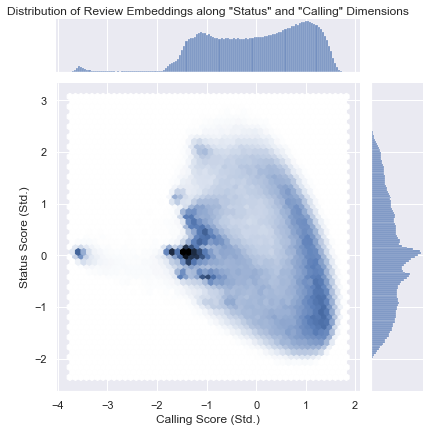

In [23]:
sns.jointplot(x="postmat_z", y="stat_z",data=df, kind="hex")
plt.xlabel('Calling Score (Std.)')
plt.ylabel('Status Score (Std.)')
plt.title('Distribution of Review Embeddings along "Status" and "Calling" Dimensions', y=1.2)
plt.savefig("hexplot.png")
plt.show()

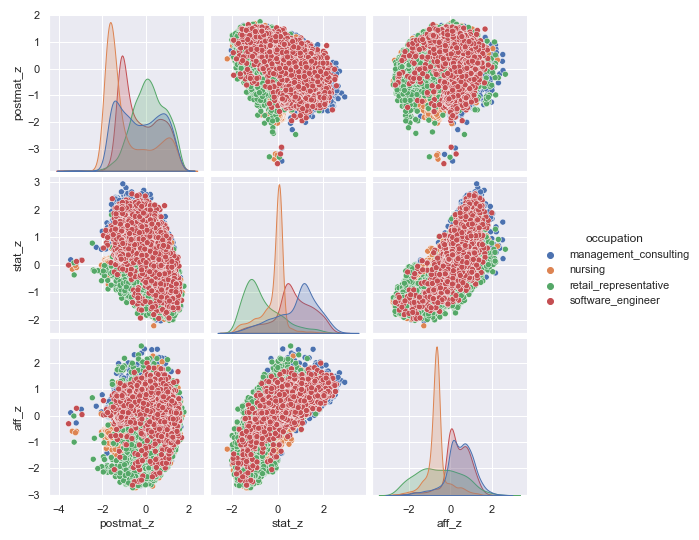

In [24]:
occ_subset = ["management_consulting", "software_engineer", "nursing", "retail_representative"]

sns.pairplot(data=df[["postmat_z", "stat_z", "aff_z", "occupation"]][(df["occupation"].isin(occ_subset)) & (df["rating"]==1)], 
             hue="occupation")
plt.savefig("pairplot2.png")
plt.close()
Image(filename="pairplot2.png") 

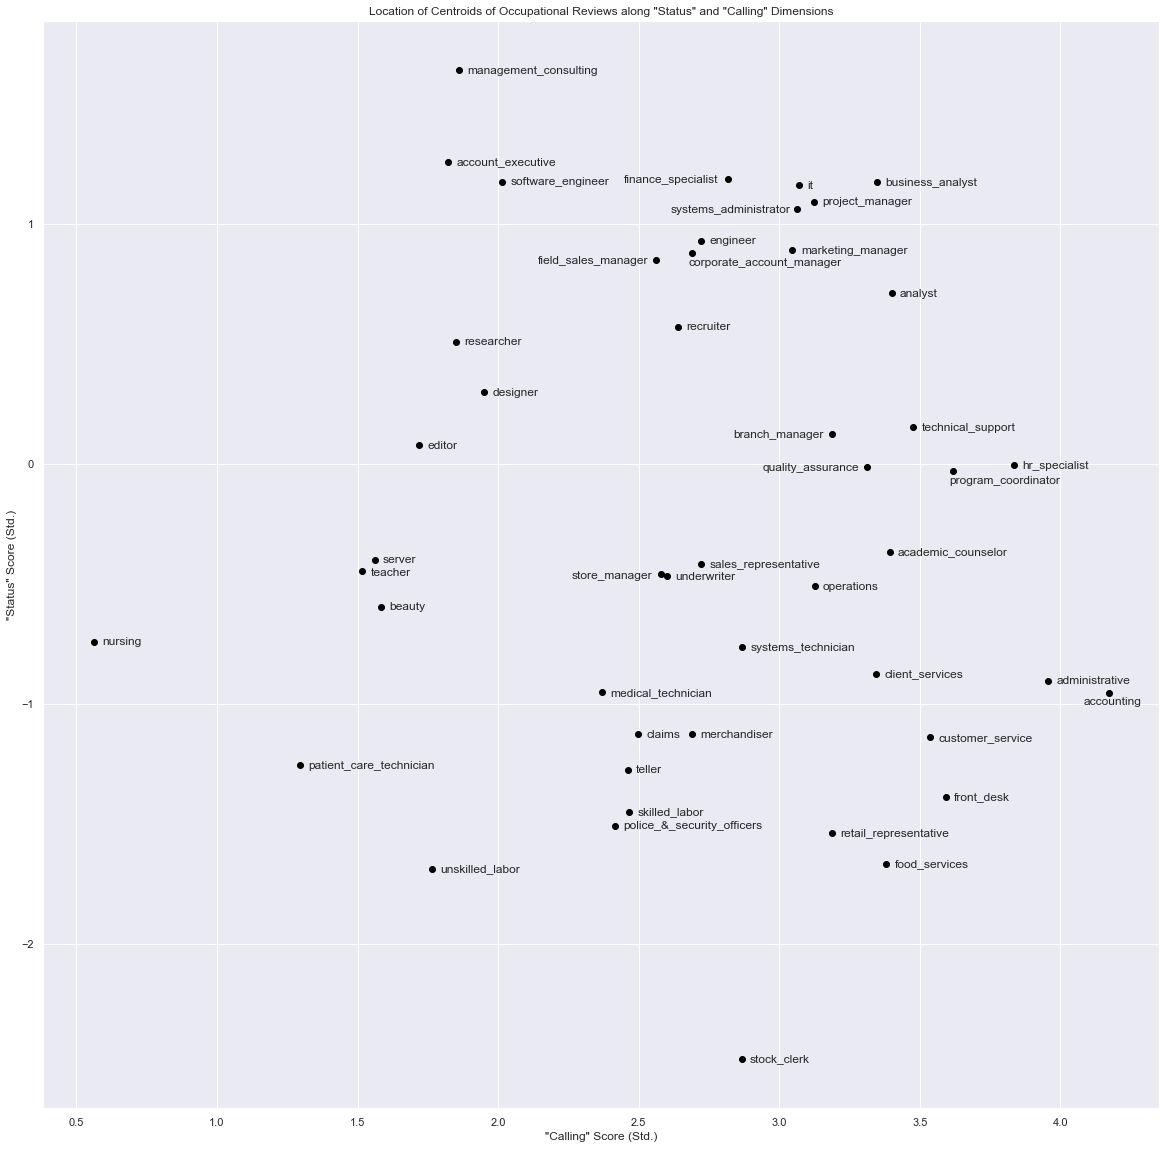

In [25]:
# without "driver" --> shift to right

remove = postmat_occs.index("driver")

plt.rcParams["figure.figsize"]=20,20
postmat_right = list(copy(postmat_vals))
postmat_right.pop(remove)
status_right = list(copy(status_vals))
status_right.pop(remove)
occs_right = list(copy(postmat_occs))
occs_right.remove("driver")
assert len(postmat_right) == len(status_right) == len(occs_right)

plt.scatter(postmat_right, status_right, color="black")
plt.xlabel('"Calling" Score (Std.)')
plt.ylabel('"Status" Score (Std.)')

for occ in occs_right:
    if occ == "teacher":
        plt.text(x=postmat_dict[occ]+0.03, y=status_dict[occ]-0.02, s=occ)
    elif occ == "accounting":
        plt.text(x=postmat_dict[occ]-0.09, y=status_dict[occ]-0.05, s=occ)
    elif occ == "store_manager":
        plt.text(x=postmat_dict[occ]-0.32, y=status_dict[occ]-0.02, s=occ)
    elif occ == "branch_manager":
        plt.text(x=postmat_dict[occ]-0.35, y=status_dict[occ]-0.015, s=occ)
    elif occ == "quality_assurance":
        plt.text(x=postmat_dict[occ]-0.37, y=status_dict[occ]-0.015, s=occ)
    elif occ == "finance_specialist":
        plt.text(x=postmat_dict[occ]-0.37, y=status_dict[occ]-0.015, s=occ)
    elif occ == "systems_administrator":
        plt.text(x=postmat_dict[occ]-0.45, y=status_dict[occ]-0.017, s=occ)
    elif occ == "field_sales_manager":
        plt.text(x=postmat_dict[occ]-0.42, y=status_dict[occ]-0.015, s=occ)
    elif occ in ["corporate_account_manager", "program_coordinator"]:
        plt.text(x=postmat_dict[occ]-0.015, y=status_dict[occ]-0.054, s=occ)
    else:
        plt.text(x=postmat_dict[occ]+0.03, y=status_dict[occ]-0.014, s=occ)
plt.title('Location of Centroids of Occupational Reviews along "Status" and "Calling" Dimensions')
plt.savefig("occ_cent_dist.png")
plt.show()

In [26]:
occ_ratings_scores = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))
occ_ratings_scores_std = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))

post_mean = np.mean(df["postmaterialism"].values)
post_std = np.std(df["postmaterialism"].values, ddof=1)
stat_mean = np.mean(df["status"].values)
stat_std = np.std(df["status"].values, ddof=1)

for occ in postmat_occs:
    lab = occ2label[occ]
    for rating in range(1,6):
        m = occ_centroids[lab][rating]
        post = apply_direction(m, postmat_direction)
        occ_ratings_scores[occ][rating]["postmaterialism"] = post
        stat = apply_direction(m, status_direction)
        occ_ratings_scores[occ][rating]["status"] = stat
        
        post_z = (post - post_mean)/post_std
        stat_z = (stat - stat_mean)/stat_std
        
        occ_ratings_scores_std[occ][rating]["postmat_z"] = post_z
        occ_ratings_scores_std[occ][rating]["status_z"] = stat_z

In [27]:
def draw_occ_shift(occ, i, j, std=False, width=0.001):
    if not std:
        post1 = occ_ratings_scores[occ][i]["postmaterialism"]
        stat1 = occ_ratings_scores[occ][i]["status"]
        post5 = occ_ratings_scores[occ][j]["postmaterialism"]
        stat5 = occ_ratings_scores[occ][j]["status"]
    else:
        post1 = occ_ratings_scores_std[occ][i]["postmat_z"]
        stat1 = occ_ratings_scores_std[occ][i]["status_z"]
        post5 = occ_ratings_scores_std[occ][j]["postmat_z"]
        stat5 = occ_ratings_scores_std[occ][j]["status_z"]
    plt.arrow(post1, stat1, post5 - post1, stat5 - stat1, shape="full", width=width)

### Difference between 1-star and 5-star Reviews for Each Occupation

In [29]:
# std = True

# plt.xlabel('"Calling" Score (Std.)')
# plt.ylabel('"Career" Score (Std.)')
# for occ in postmat_occs:
#     draw_occ_shift(occ, 1, 5, std, width=0.01)
#     if not std:
#         plt.text(x=occ_ratings_scores[occ][1]["postmaterialism"], y=occ_ratings_scores[occ][1]["status"], s=f"{occ}: 1")
#         plt.text(x=occ_ratings_scores[occ][5]["postmaterialism"], y=occ_ratings_scores[occ][5]["status"], s=f"{occ}: 5")
#     else:
#         plt.text(x=occ_ratings_scores_std[occ][5]["postmat_z"], y=occ_ratings_scores_std[occ][5]["status_z"], s=f"{occ}")

# plt.title("Unattractive Visualization of the Shift from 1-star to 5-star Reviews along Career and Calling Dimensions")        
# plt.show()